In [653]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # for plot visualization
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse

In [654]:
weather_df = pd.read_csv(r'testset.csv', parse_dates=['datetime_utc'], index_col='datetime_utc')
weather_df.head()

,_dewptm,_fog,_hail,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_wdird,_wspdm
datetime_utc,,,,,,,,,,,,,
1996-11-01 11:00:00,9.0,0,0,27.0,NaN,1010.0,0,0,30.0,0,0,280.0,7.4
1996-11-01 12:00:00,10.0,0,0,32.0,NaN,-9999.0,0,0,28.0,0,0,0.0,NaN
1996-11-01 13:00:00,11.0,0,0,44.0,NaN,-9999.0,0,0,24.0,0,0,0.0,NaN
1996-11-01 14:00:00,10.0,0,0,41.0,NaN,1010.0,0,0,24.0,0,0,0.0,NaN
1996-11-01 16:00:00,11.0,0,0,47.0,NaN,1011.0,0,0,23.0,0,0,0.0,0.0


In [655]:
weather_df = weather_df.loc[:,[' _hum', ' _tempm']]
weather_df = weather_df.rename(index=str, columns={ ' _hum': 'humidity', ' _tempm': 'temprature'})
weather_df.head()

,humidity,temprature
datetime_utc,,
1996-11-01 11:00:00,27.0,30.0
1996-11-01 12:00:00,32.0,28.0
1996-11-01 13:00:00,44.0,24.0
1996-11-01 14:00:00,41.0,24.0
1996-11-01 16:00:00,47.0,23.0


In [656]:
weather_df.index = pd.to_datetime(weather_df.index)
print(weather_df.index)

DatetimeIndex(['1996-11-01 11:00:00', '1996-11-01 12:00:00',
               '1996-11-01 13:00:00', '1996-11-01 14:00:00',
               '1996-11-01 16:00:00', '1996-11-01 17:00:00',
               '1996-11-01 18:00:00', '1996-11-01 19:00:00',
               '1996-11-01 20:00:00', '1996-11-01 21:00:00',
               ...
               '2017-04-23 15:00:00', '2017-04-23 18:00:00',
               '2017-04-23 21:00:00', '2017-04-24 00:00:00',
               '2017-04-24 03:00:00', '2017-04-24 06:00:00',
               '2017-04-24 09:00:00', '2017-04-24 12:00:00',
               '2017-04-24 15:00:00', '2017-04-24 18:00:00'],
              dtype='datetime64[ns]', name='datetime_utc', length=100990, freq=None)


In [657]:
# def list_and_visualize_missing_data(dataset):
#     # Listing total null items and its percent with respect to all nulls
#     total = dataset.isnull().sum().sort_values(ascending=False)
#     percent = ((dataset.isnull().sum())/(dataset.isnull().count())).sort_values(ascending=False)
#     missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
#     missing_data = missing_data[missing_data.Total > 0]
    
#     missing_data.plot.bar(subplots=True, figsize=(16,9))

# list_and_visualize_missing_data(weather_df)

In [658]:
# will fill with previous valid value
weather_df.ffill(inplace=True)
weather_df[weather_df.isnull()].count()
weather_df.describe()

,humidity,temprature
count,100990.000000,100990.000000
mean,57.957422,25.438222
std,23.821218,8.487994
min,4.000000,1.000000
25%,39.000000,19.000000
50%,59.000000,27.000000
75%,78.000000,32.000000
max,243.000000,90.000000


In [659]:
weather_df = weather_df[weather_df.temprature < 50]
weather_df = weather_df[weather_df.humidity <= 100]
weather_df.describe()

,humidity,temprature
count,100983.000000,100983.000000
mean,57.955309,25.436361
std,23.805467,8.482944
min,4.000000,1.000000
25%,39.000000,19.000000
50%,59.000000,27.000000
75%,78.000000,32.000000
max,100.000000,47.000000


C:\Users\sajal\AppData\Local\Temp\ipykernel_32056\1728652007.py:2: FutureWarning: DatetimeIndexResampler.fillna is deprecated and will be removed in a future version. Use obj.ffill(), obj.bfill(), or obj.nearest() instead.
  weather_df['2015':'2016'].resample('D').fillna(method='pad').plot(subplots=True, figsize=(20,12))


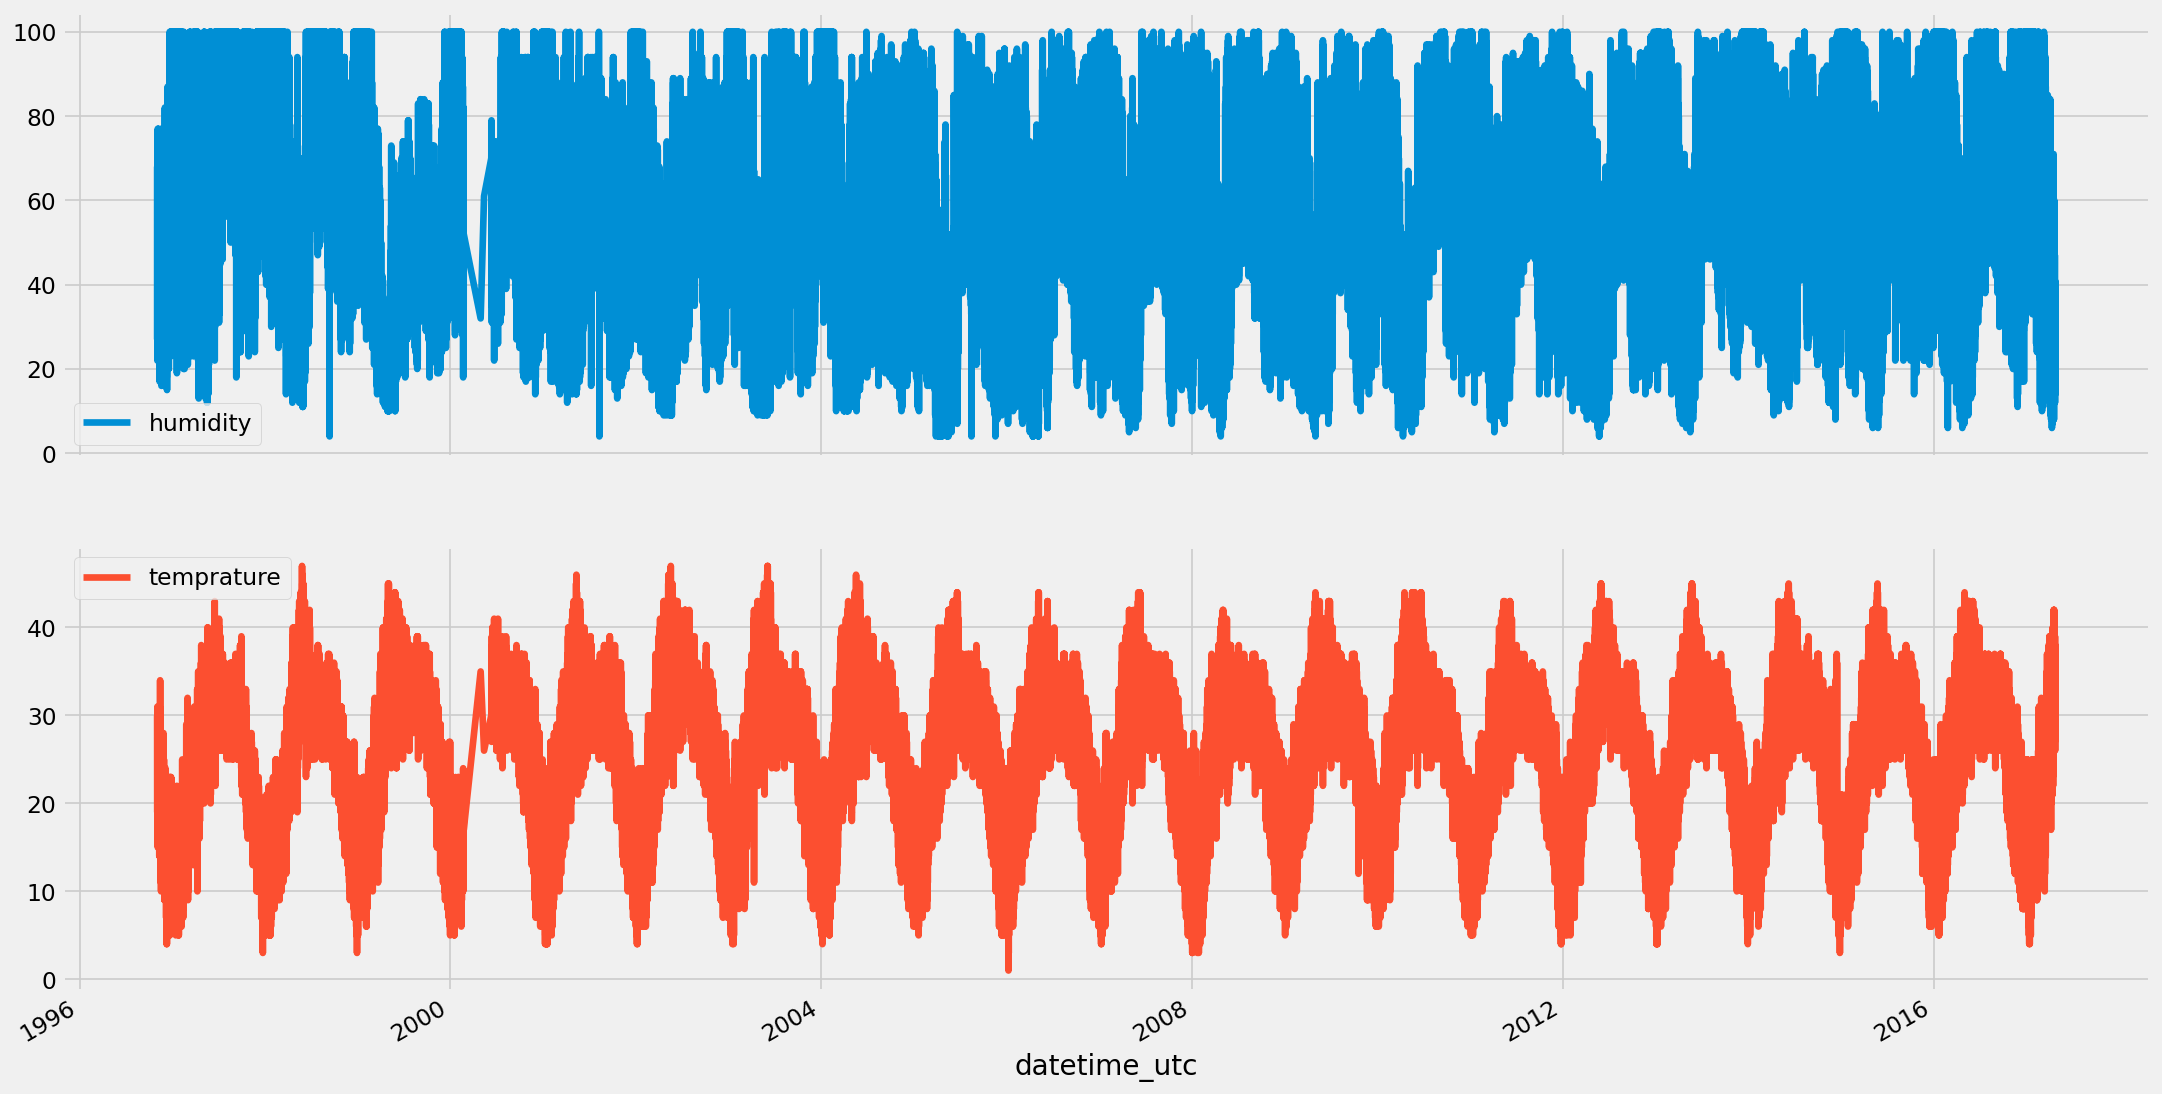

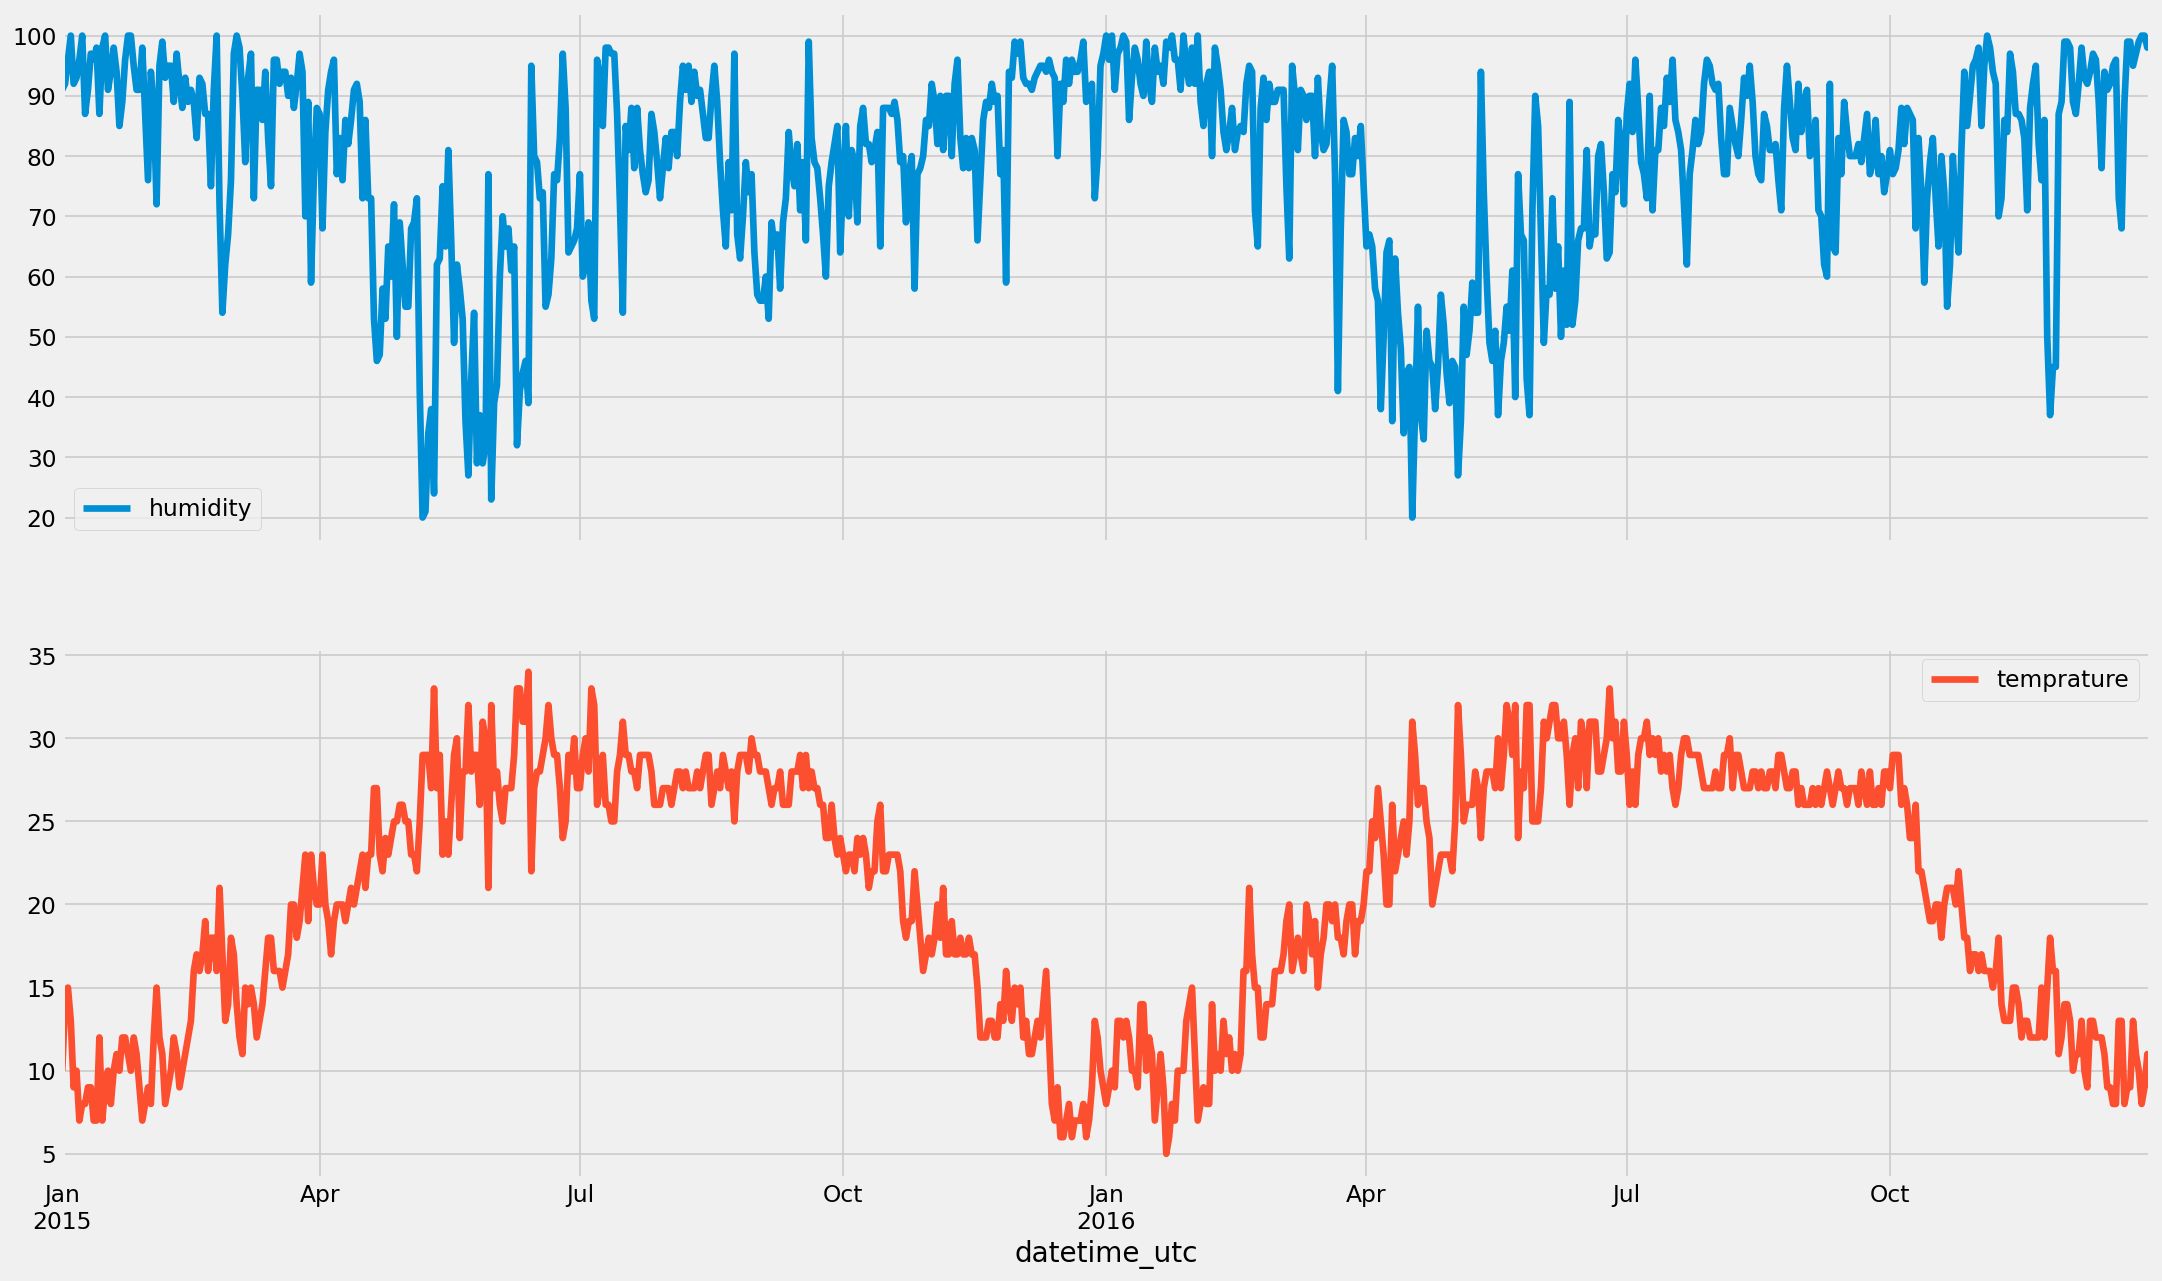

In [660]:
weather_df.plot(subplots=True, figsize=(20,12))
weather_df['2015':'2016'].resample('D').fillna(method='pad').plot(subplots=True, figsize=(20,12))
plt.show()

C:\Users\sajal\AppData\Local\Temp\ipykernel_32056\4264400973.py:4: FutureWarning: DatetimeIndexResampler.fillna is deprecated and will be removed in a future version. Use obj.ffill(), obj.bfill(), or obj.nearest() instead.
  resampled_df = weather_df['2015':'2016'].resample('D').fillna(method='pad')


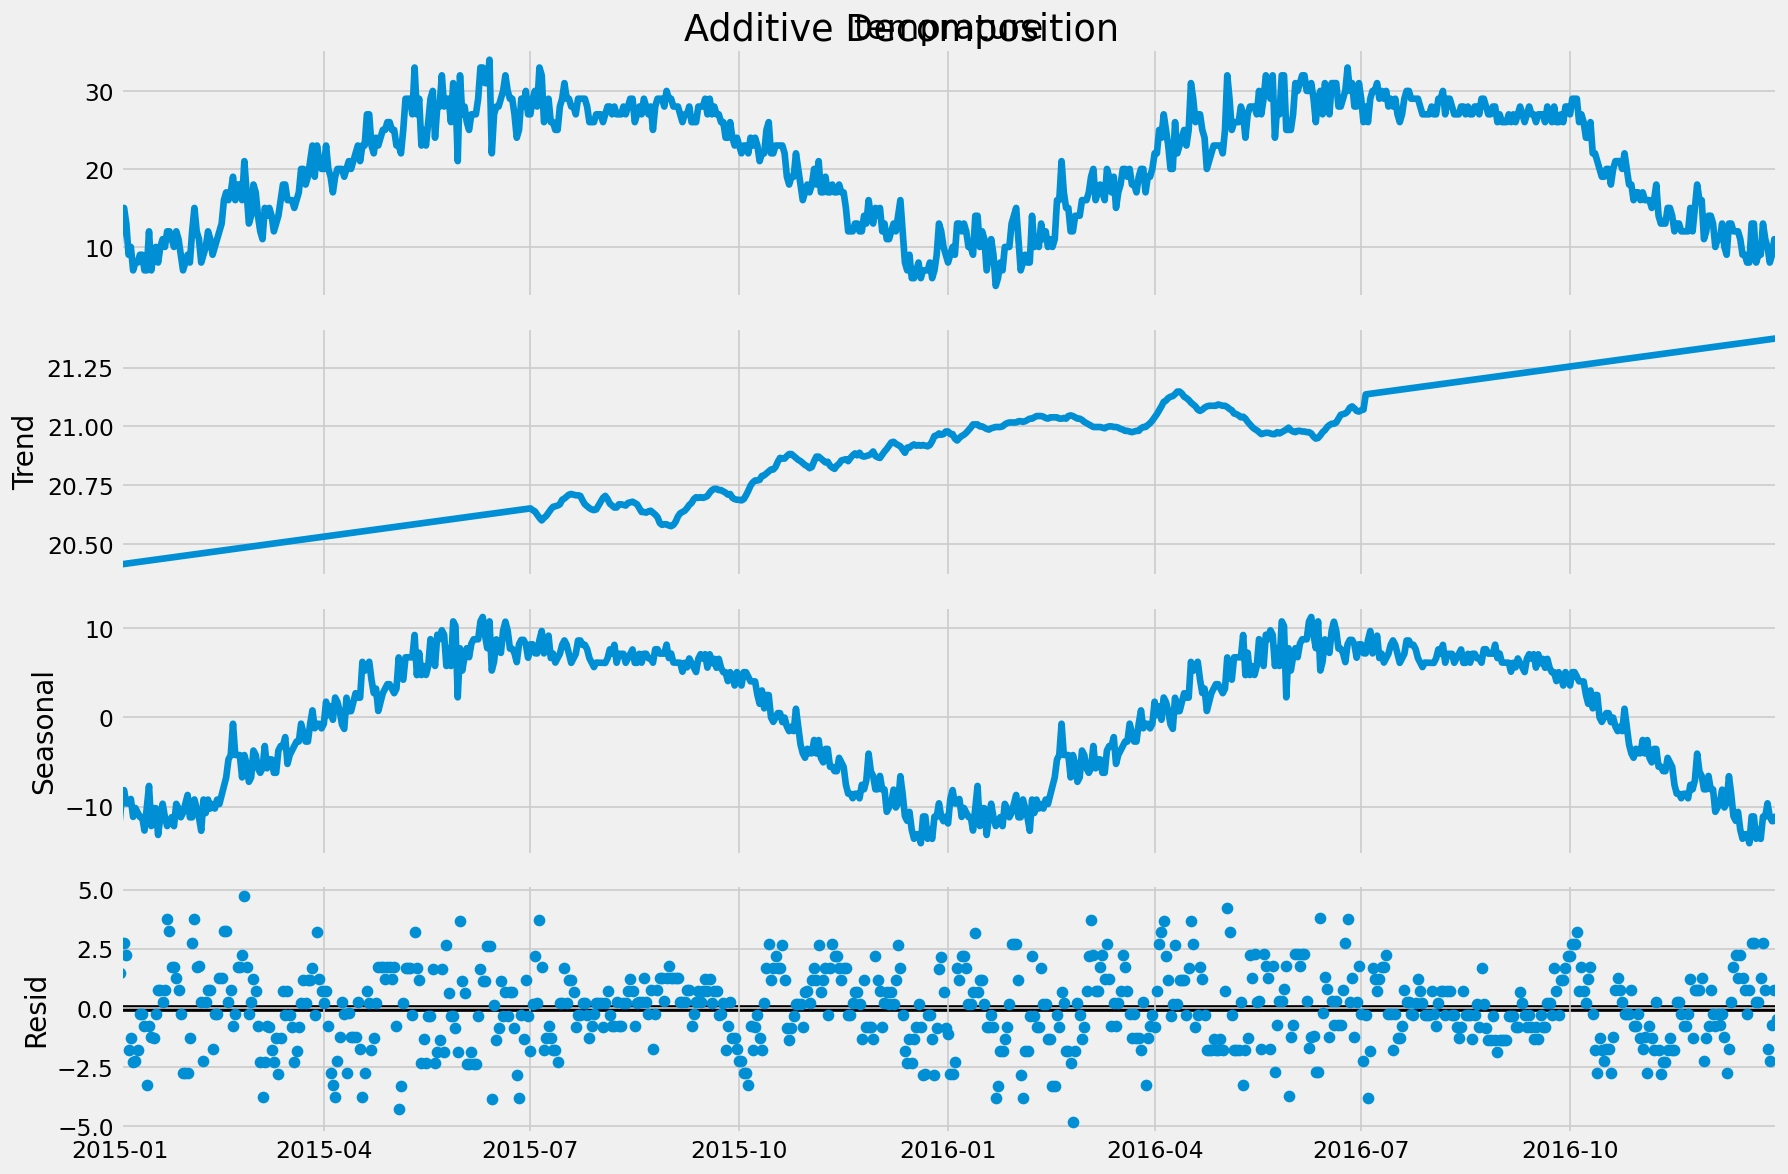

In [661]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Resample and fill missing values
resampled_df = weather_df['2015':'2016'].resample('D').fillna(method='pad')
temperature_column = resampled_df['temprature']

# Additive Decomposition
result_add = seasonal_decompose(temperature_column, model='additive', extrapolate_trend='freq', period=365)

# Plot
plt.rcParams.update({'figure.figsize': (15, 10)})
result_add.plot().suptitle('Additive Decomposition', fontsize=22)
plt.show()


In [693]:
train_df = weather_df['2000':'2015'].resample('M').mean().fillna(method='pad')
train_df.drop('humidity', axis=1, inplace=True)
test_df = weather_df['2016':'2017'].resample('M').mean().fillna(method='pad')
test_df.drop('humidity', axis=1, inplace=True)
print(train_df)

              temprature
datetime_utc            
2000-01-31     13.707670
2000-02-29     14.918977
2000-03-31     14.918977
2000-04-30     35.000000
2000-05-31     26.000000
...                  ...
2015-08-31     30.235507
2015-09-30     30.665254
2015-10-31     26.827869
2015-11-30     20.754167
2015-12-31     14.975709

[192 rows x 1 columns]


C:\Users\sajal\AppData\Local\Temp\ipykernel_32056\3731187306.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df = weather_df['2000':'2015'].resample('M').mean().fillna(method='pad')
C:\Users\sajal\AppData\Local\Temp\ipykernel_32056\3731187306.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df = weather_df['2016':'2017'].resample('M').mean().fillna(method='pad')


In [663]:
def plot_Moving_Avg(time_series):
    # Calculate moving average and rolling standard deviation
    moving_avg = time_series.rolling(window=12).mean()
    rolling_std = time_series.rolling(window=12).std()

    # Plotting
    plt.figure(figsize=(22, 10))
    plt.plot(time_series, label='Actual Mean')
    plt.plot(moving_avg, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    
    # Labels and Title
    plt.xlabel("Time Points")
    plt.ylabel("Expected Temperature")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    
    # Legend
    plt.legend()
    
    # Show the plot
    plt.show()


In [664]:
def dickey_fuller_test(ts):
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('Critical Values:' ,result[4])

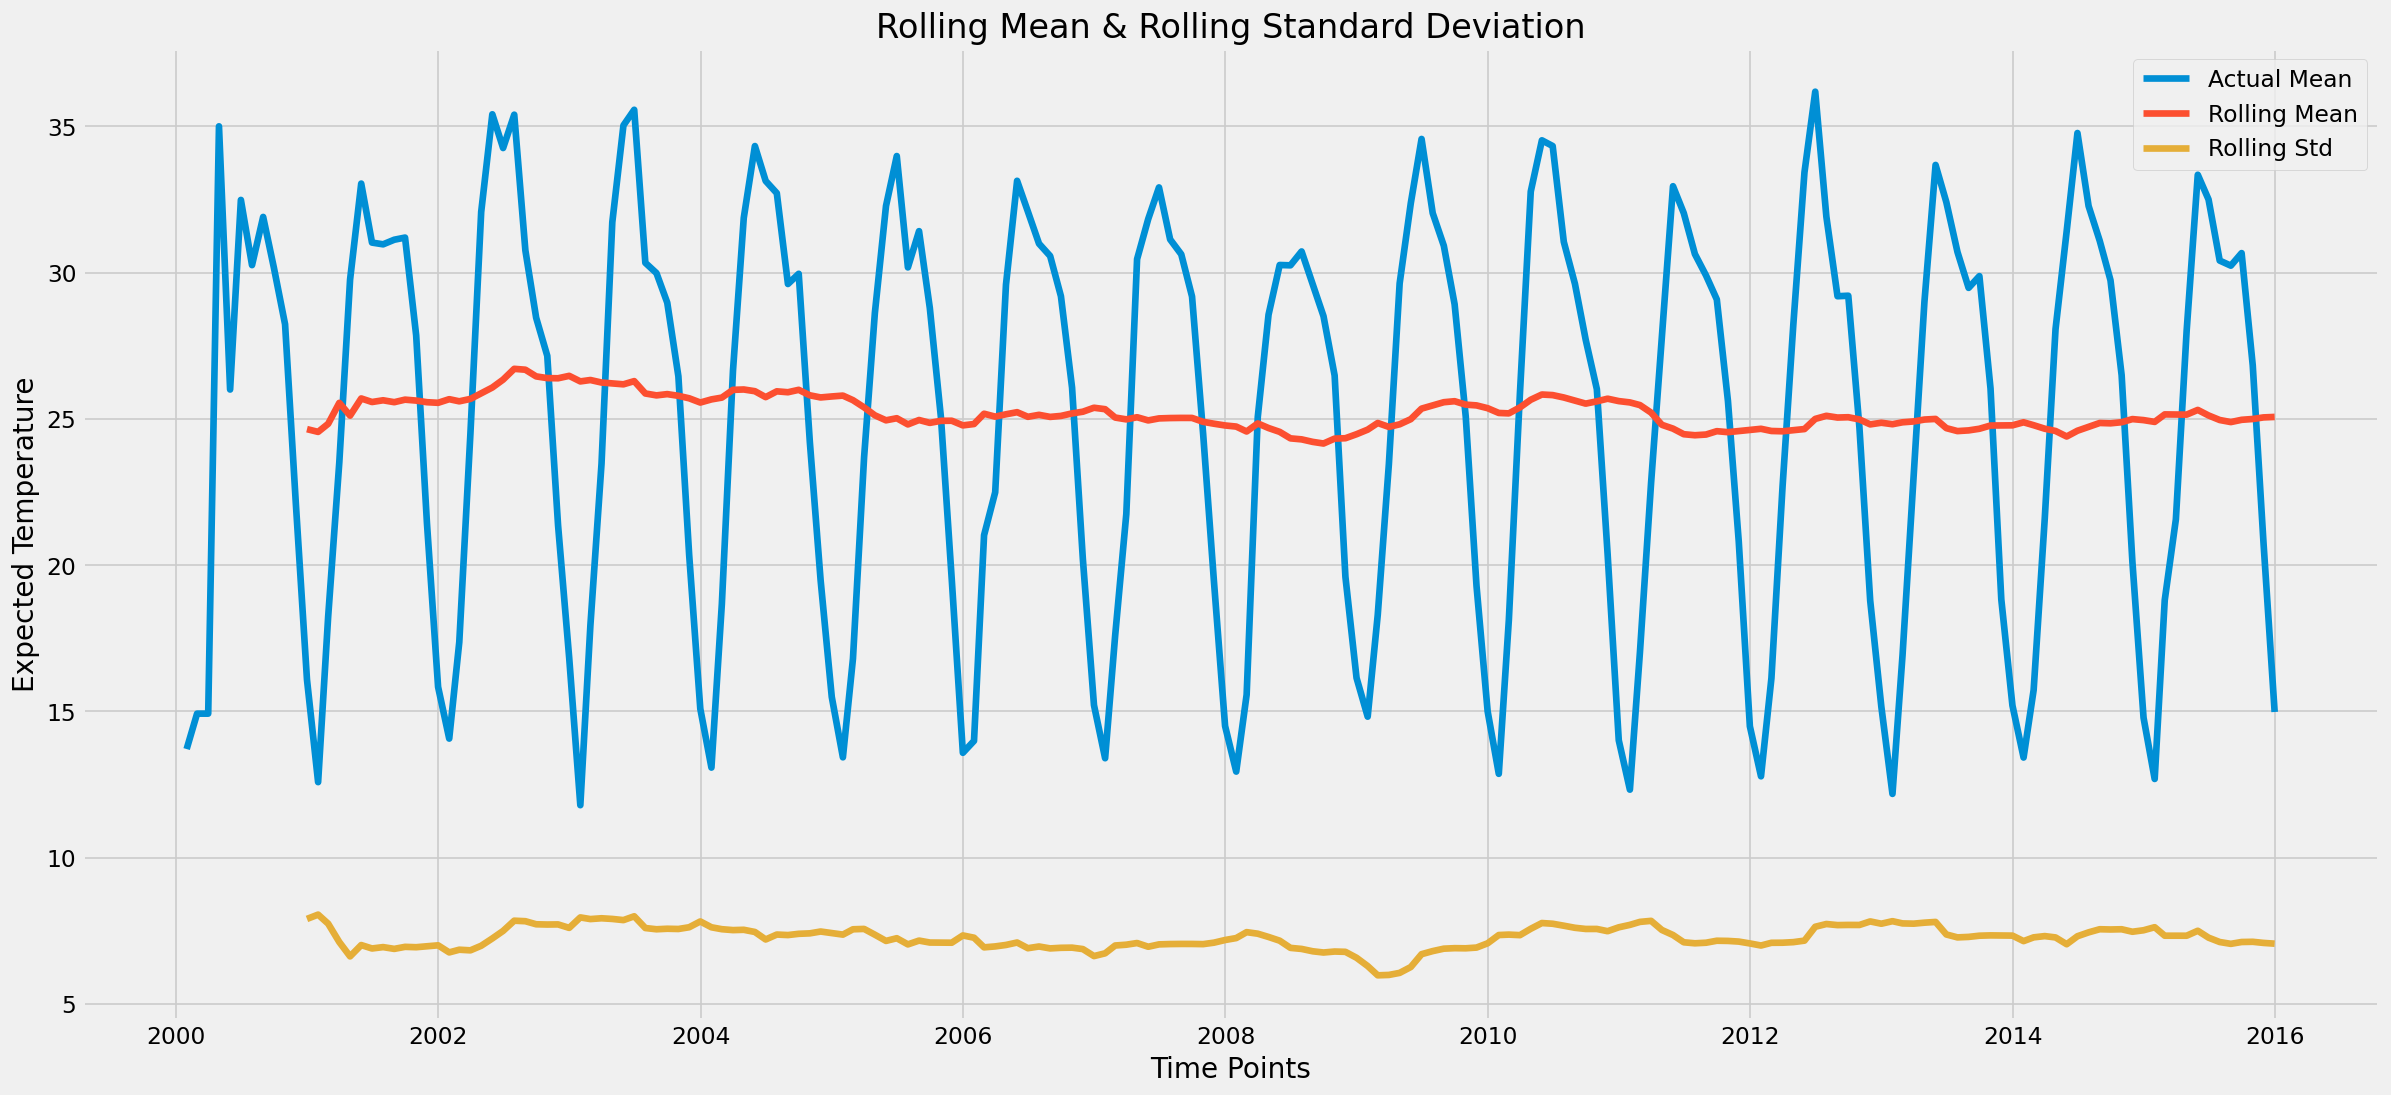

Test statistic:  -2.1269952502980276
Critical Values: {'1%': -3.4674201432469816, '5%': -2.877826051844538, '10%': -2.575452082332012}


In [665]:
plot_Moving_Avg(train_df.temprature)
dickey_fuller_test(train_df.temprature)

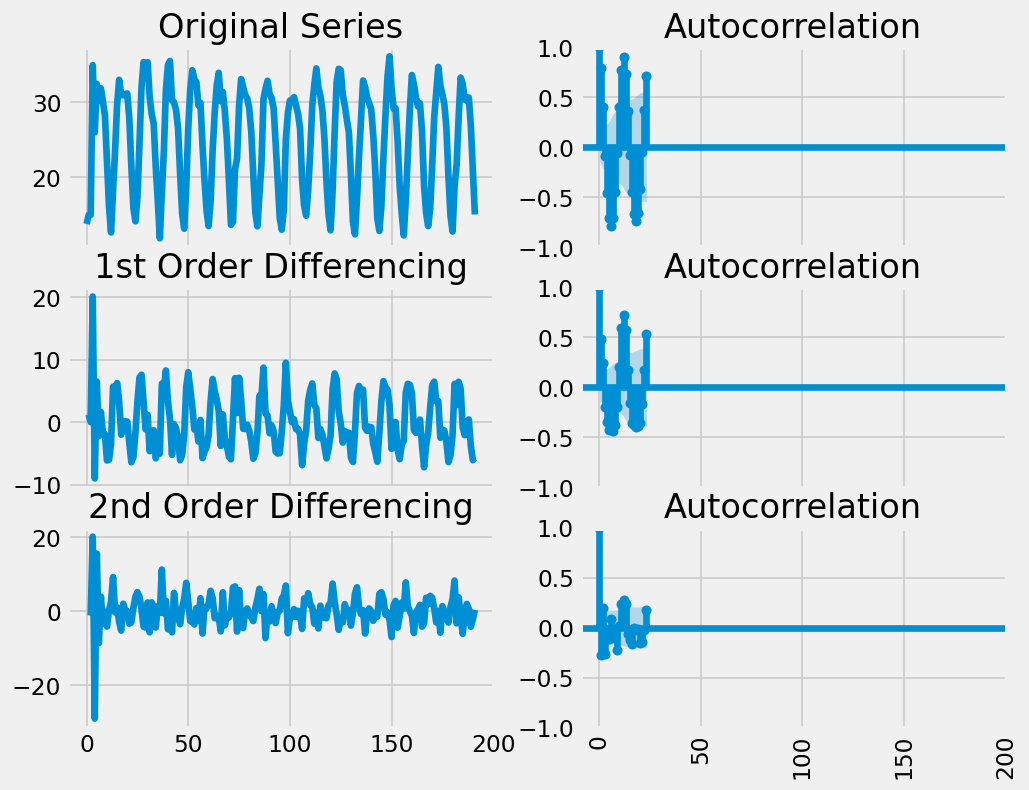

In [666]:
plt.rcParams.update({'figure.figsize': (9, 7), 'figure.dpi': 120})

fig, axes = plt.subplots(3, 2, sharex=True)

# Original Series
axes[0, 0].plot(train_df.values)
axes[0, 0].set_title('Original Series')
plot_acf(train_df.values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train_df.diff().values)
axes[1, 0].set_title('1st Order Differencing')
plot_acf(train_df.diff().dropna().values, ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train_df.diff().diff().values)
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train_df.diff().diff().dropna().values, ax=axes[2, 1])

# Rotate x-axis labels for better readability
plt.xticks(rotation='vertical')

# Show the plot
plt.show()


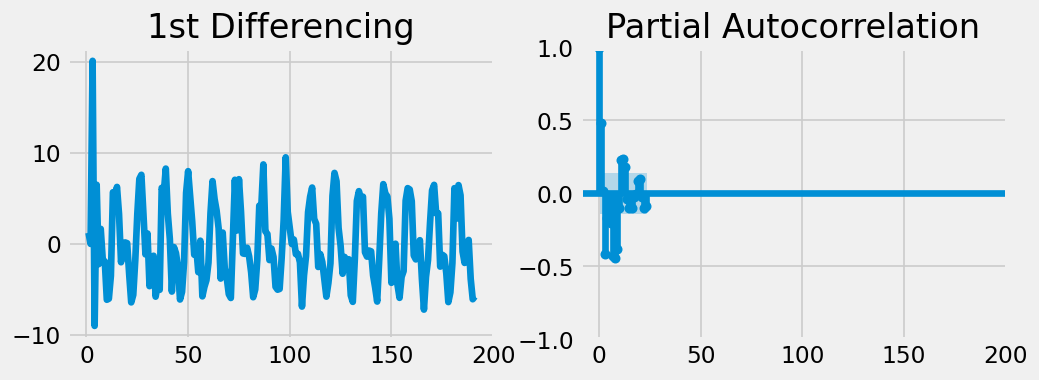

In [667]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

fig, axes = plt.subplots(1, 2, sharex=True)

# 1st Differencing
axes[0].plot(train_df.diff().values)
axes[0].set_title('1st Differencing')

# Set y-axis limit for better visualization
axes[1].set(ylim=(0, 5))

# PACF plot
plot_pacf(train_df.diff().dropna().values, ax=axes[1])

# Show the plot
plt.show()


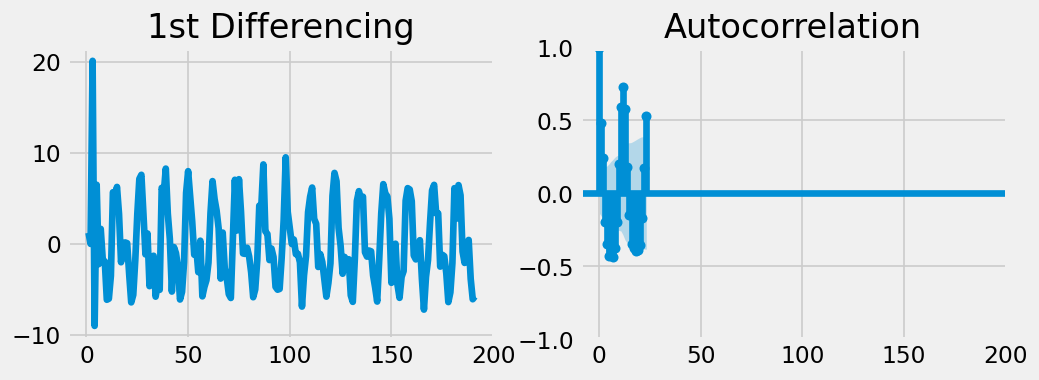

In [668]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train_df.diff().values); axes[0].set_title('1st Differencing')
# plt.show()
axes[1].set(ylim=(0,1.2))
plot_acf(train_df.diff().dropna().values, ax=axes[1])
plt.show()

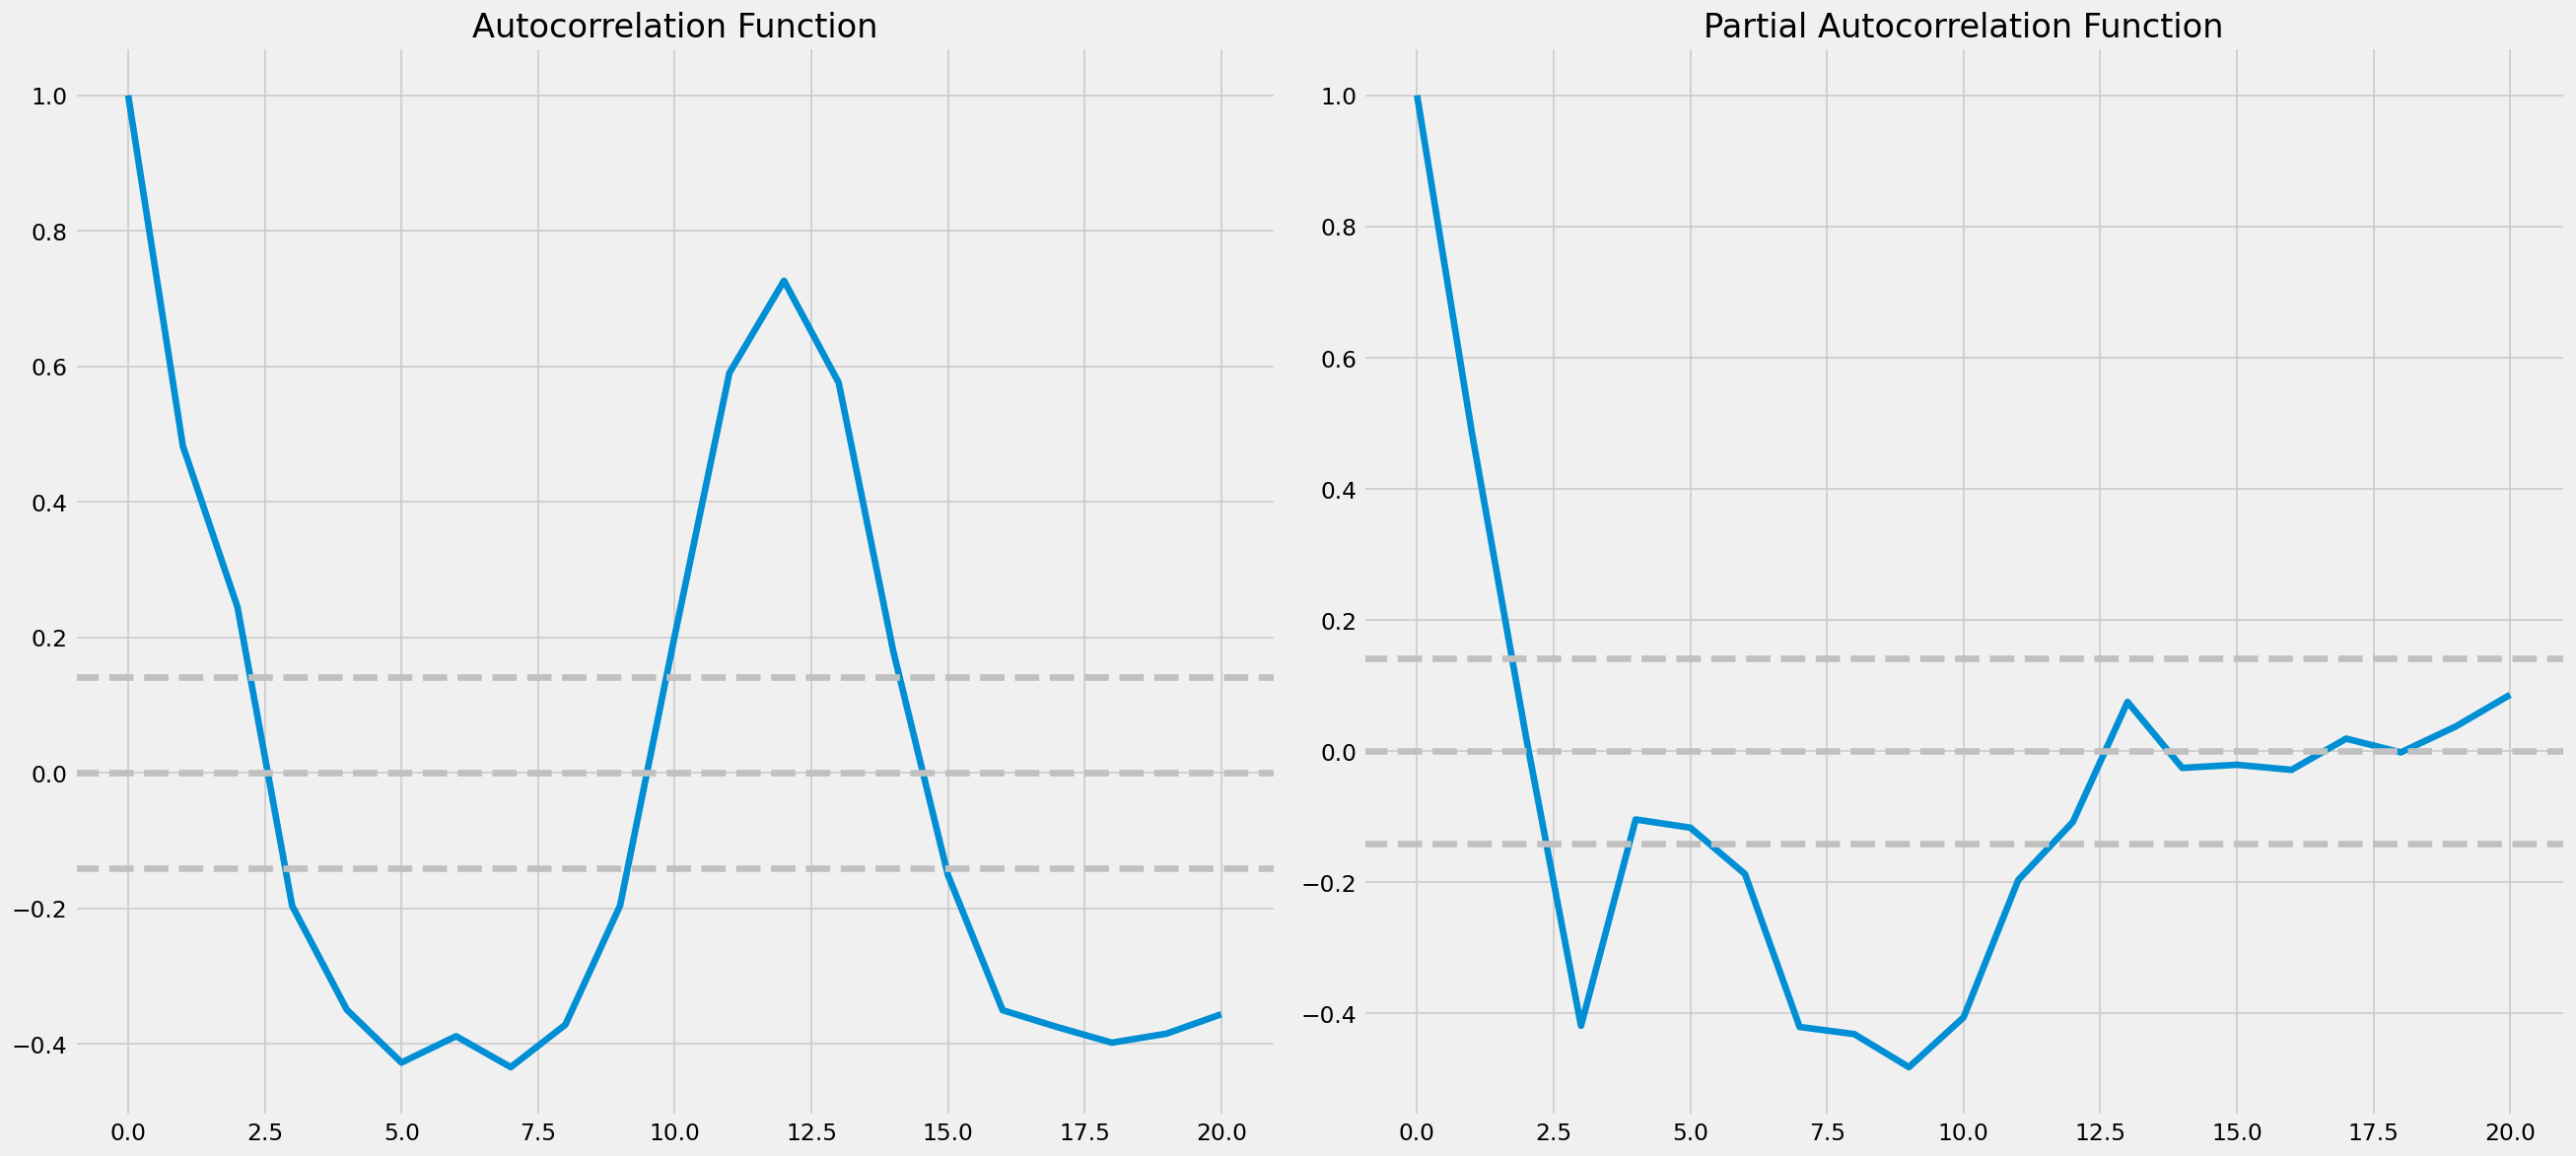

In [669]:
acf_lag = acf(train_df.diff().dropna().values, nlags=20)
pacf_lag = pacf(train_df.diff().dropna().values, nlags=20, method='ols')

plt.figure(figsize=(22, 10))

plt.subplot(121)
plt.plot(acf_lag)
plt.axhline(y=0, linestyle='--', color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.diff().values)), linestyle='--', color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.diff().values)), linestyle='--', color='silver')
plt.title("Autocorrelation Function")

plt.subplot(122)
plt.plot(pacf_lag)
plt.axhline(y=0, linestyle='--', color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.diff().values)), linestyle='--', color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.diff().values)), linestyle='--', color='silver')
plt.title("Partial Autocorrelation Function")

# Ensure plots do not overlap
plt.tight_layout()

# Show the plot
plt.show()


In [670]:
model = ARIMA(train_df.values, order=(2,0,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  192
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -454.355
Date:                Mon, 13 Nov 2023   AIC                            920.709
Time:                        16:55:06   BIC                            940.254
Sample:                             0   HQIC                           928.625
                                - 192                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.1916      0.142    177.990      0.000      24.914      25.469
ar.L1          1.6785      0.027     61.309      0.000       1.625       1.732
ar.L2         -0.9519      0.027    -35.284      0.0

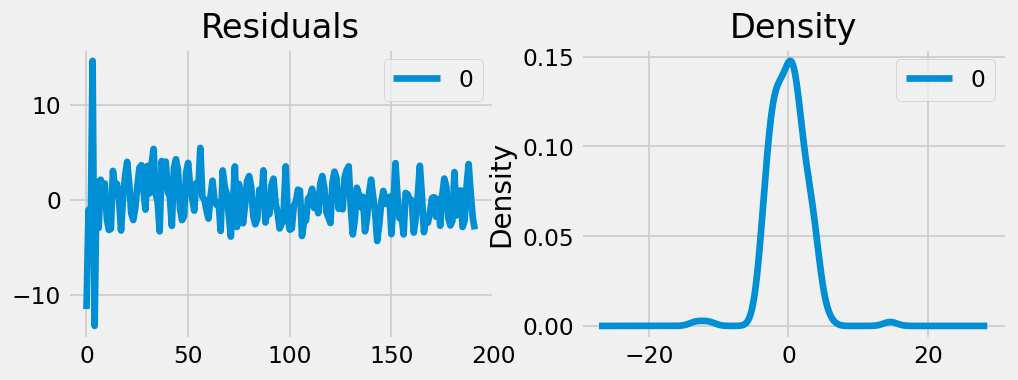

In [671]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

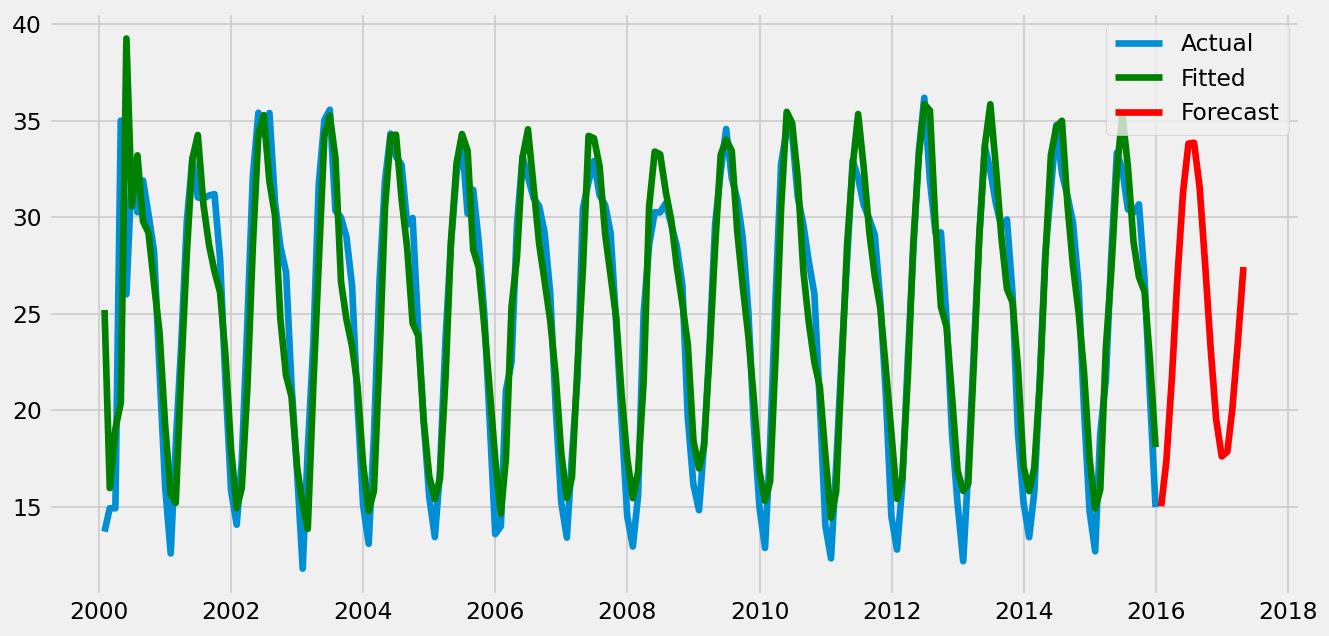

In [672]:
import matplotlib.pyplot as plt

# Fitted values on the training data
fitted_values = model_fit.fittedvalues

# Forecast on the test data
forecast = model_fit.get_forecast(steps=len(test_df))
conf_int = forecast.conf_int()

# Plotting the actual vs. fitted values
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df, label='Actual')
plt.plot(train_df.index, fitted_values, label='Fitted', color='green')
plt.plot(test_df.index, forecast.predicted_mean, label='Forecast', color='red')
# plt.fill_between(test_df.index, conf_int['temprature'], conf_int['temprature'], color='red', alpha=0.2)
plt.legend()
plt.show()


c:\Users\sajal\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


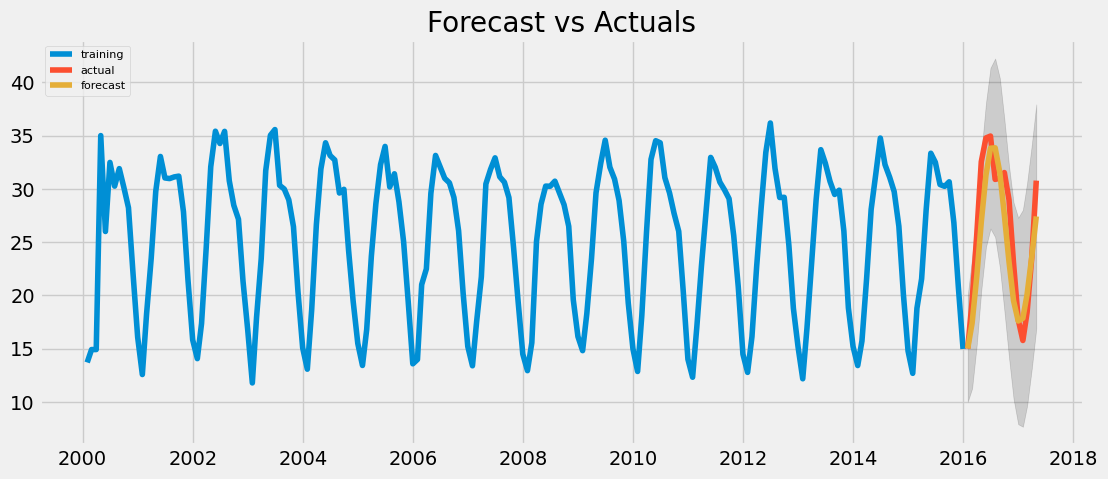

In [673]:
# Forecast
forecast = model_fit.get_forecast(steps=16, alpha=0.05)  # 95% conf

# Extract forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Make as pandas series
fc_series = pd.Series(forecast_values, index=test_df.index)
lower_series = pd.Series(conf_int[:, 0], index=test_df.index)
upper_series = pd.Series(conf_int[:, 1], index=test_df.index)

# Plot
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train_df, label='training')
plt.plot(test_df, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [674]:
arima_rmse_error = rmse(test_df['temprature'], forecast_values)
arima_mse_error = arima_rmse_error**2
mean_value = test_df['temprature'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}' )

MSE Error: 9.64574791519329
RMSE Error: 3.1057604407283717
Mean: 25.884432843781127


In [675]:
import itertools

# Define the p, d, and q parameters to take any value between 0 and 2
p_values = d_values = q_values = range(0, 2)

# Generate all different combinations of p, d, and q triplets
pdq_combinations = list(itertools.product(p_values, d_values, q_values))

# Generate all different combinations of seasonal p, d, and q triplets
seasonal_pdq_combinations = [(x[0], x[1], x[2], 12) for x in pdq_combinations]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq_combinations[1], seasonal_pdq_combinations[1]))
print('SARIMAX: {} x {}'.format(pdq_combinations[1], seasonal_pdq_combinations[2]))
print('SARIMAX: {} x {}'.format(pdq_combinations[2], seasonal_pdq_combinations[3]))
print('SARIMAX: {} x {}'.format(pdq_combinations[2], seasonal_pdq_combinations[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [676]:
# import warnings
# warnings.filterwarnings("ignore") # specify to ignore warning messages

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(one_step_df.T_mu_actual,
#                                                         order=param,
#                                                         seasonal_order=param_seasonal,
#                                                         enforce_stationarity=False,
#                                                         enforce_invertibility=False)

#             results = mod.fit()

#             print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

In [677]:
# Import the statsmodels library for using SARIMAX model
import statsmodels.api as sm

# Fit the SARIMAX model using optimal parameters
mod = sm.tsa.statespace.SARIMAX(train_df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

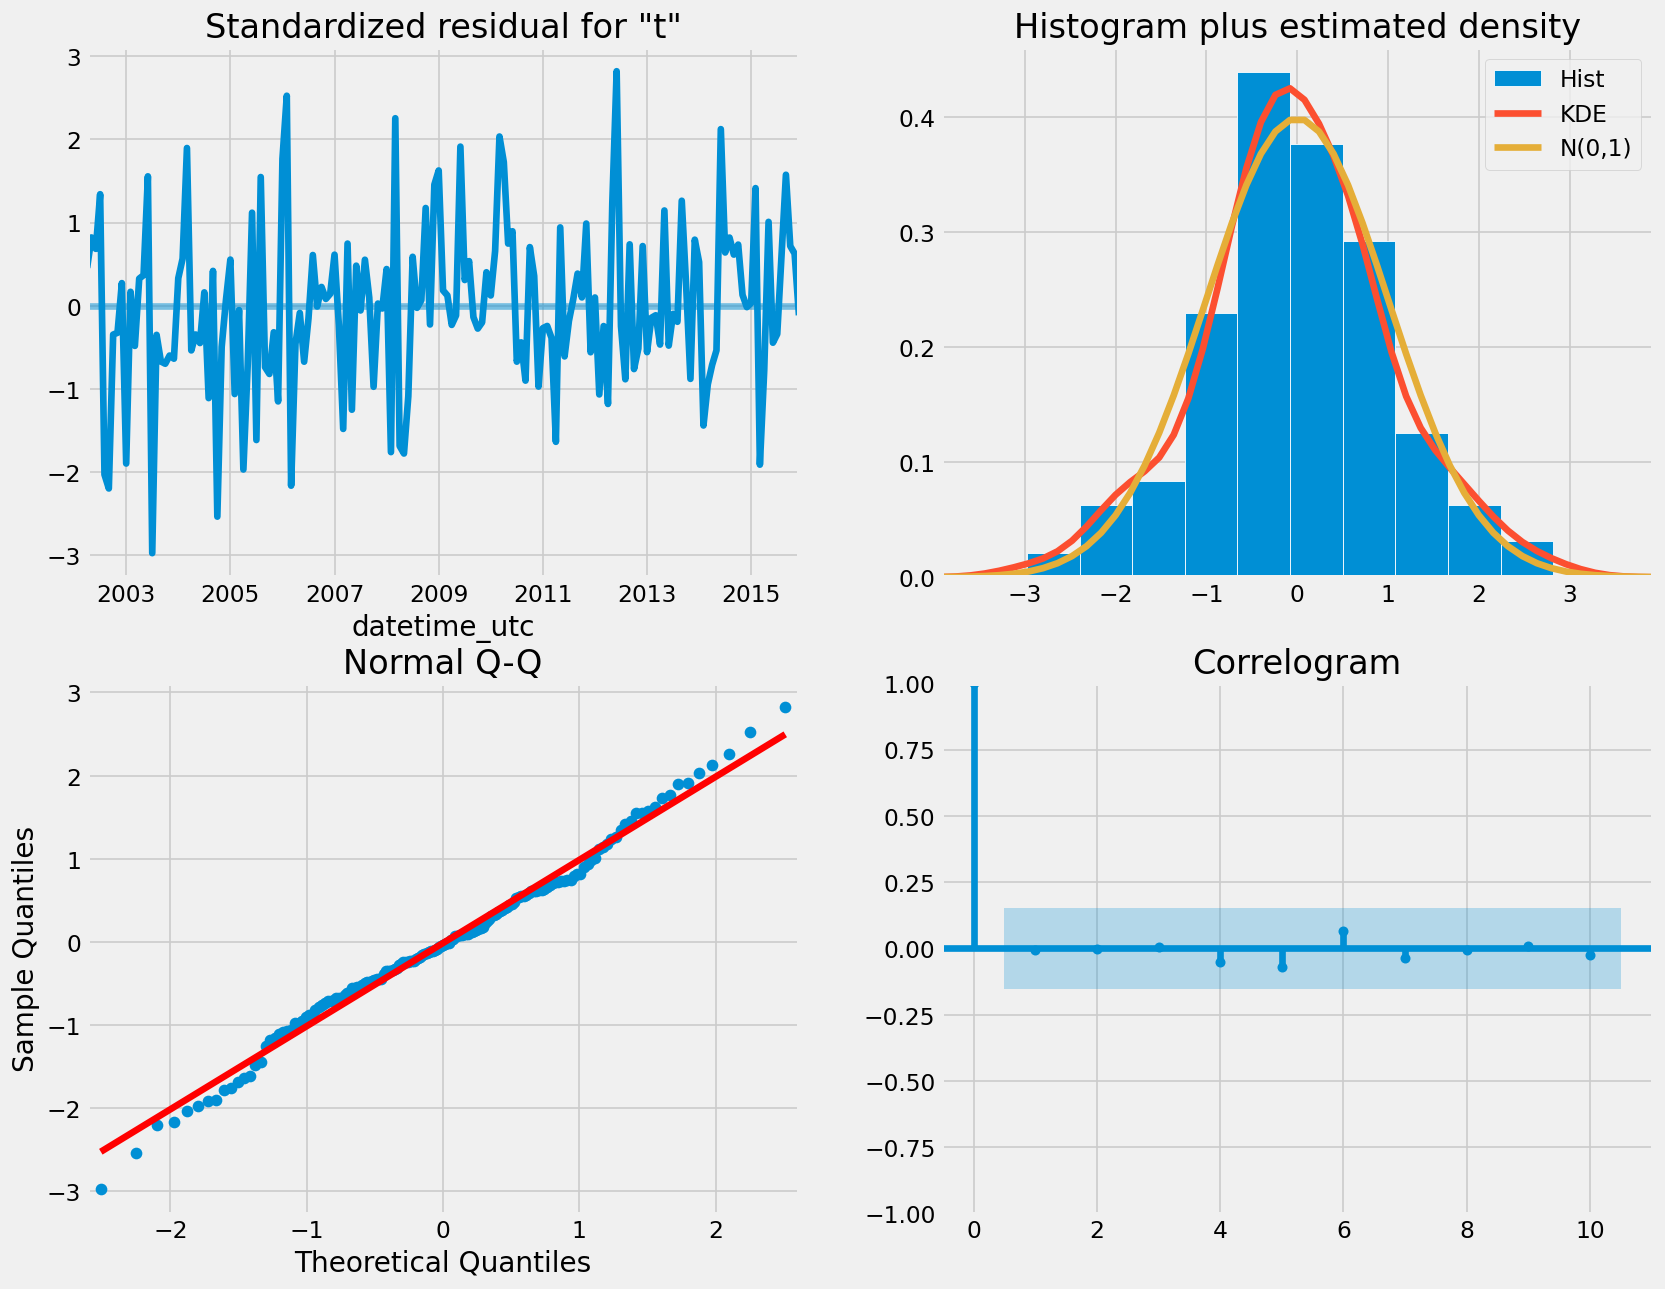

In [678]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [679]:
pred = results.get_prediction(start=pd.to_datetime('2006-12-31'), dynamic=False)
pred_ci = pred.conf_int()

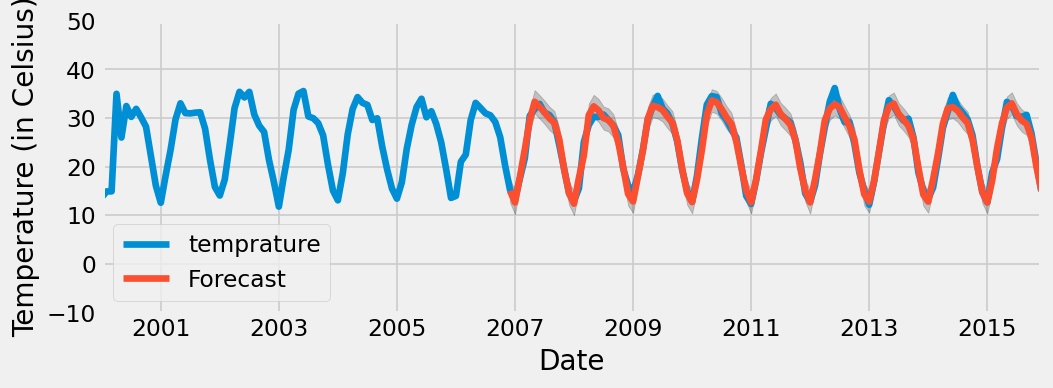

In [680]:
ax = train_df.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-10,50])
plt.legend()
plt.show()

In [695]:
arima_rmse_error = rmse(train_df['2006-12-31':]['temprature'], pred.predicted_mean)
arima_mse_error = arima_rmse_error**2
mean_value = train_df['2006-12-31':]['temprature'].mean()

print(f'MSE Error: {arima_mse_error}\n RMSE Error: {arima_rmse_error}\n Mean: {mean_value}') 

MSE Error: 1.207009295082351
 RMSE Error: 1.0986397476344787
 Mean: 24.854102042589535
